In [1]:
import numpy as np
from sklearn.decomposition import PCA 
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import ComplementNB
import os
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import MinMaxScaler

In [2]:
#缩小图片规格，以减少计算量及因图片错误引起的无关因素规格为113x90
def depart(initial_matrix):
    kl = initial_matrix[15:]
    tk = []
    for i in range(113):    
        t = kl[i][20:110]
        tk.append(t)
    return tk
#离散处理数据像素，使其可能取值数量为17
def lisan(ol):
    for i in range(113):
        for j in range(90):
            ol[i][j] = (ol[i][j]//15)*15+7
    return ol
def cou_male(a):
    '''
    统计男性数量
    '''
    t = 0
    for i in a:
        if i==1:
            t += 1
    return t
#寻找男性坐标
def findex(a):
    num = []
    for i in range(len(a)):
        if a[i] == 1:
            num.append(i)
    return num
#计算权重，注意，此时特征向量已经拉长处理
def weigh(data_x,data_y):
    kp = findex(data_y)#记录男性坐标
    k = [i for i in range(len(data_y))]
    #得出女性坐标
    for i in kp:
        k.remove(i)
    al = [0]*len(data_x[0])#建立特征向量的空数组
    #循环求解
    for n in kp:
        for t in k:
            for i in range(len(data_x[0])):
                #不同则加一
                if data_x[n][i]!=data_x[t][i]:
                    al[i] += 1
    he = sum(al)
    tp = []
    for i in range(len(al)):
        tp.append(al[i]/he)
    tj = tp.copy()
    tj.sort()
    a = []
    for i in tp:
        tpk = (i-tj[0])/(tj[len(tp)-1]-tj[0])
        a.append(tpk)
    for i in range(len(a)):
        a[i] += 1 
    for i in range(len(a)):
        if a[i] != 1:
            a[i] = a[i]*4
    a = np.array(a)
    return a    

In [8]:
# 源数据处理
all_file = os.listdir('./face/rawdata')
# 读取所有data_x数据,  有问题的数据：第1186个，2412号；第1190个，2416号 ；2021号
data_x = np.zeros((len(all_file),128,128))
data_y = np.zeros(len(all_file))
data1_x = np.zeros((len(all_file),113,90))
data2_x = np.zeros((len(all_file),113,90))
# 将两个数据标签整理再一起
f = open('./face/faceDR','r')
r1 = f.readlines()
f.close()

f = open('./face/faceDS','r')
r2 = f.readlines()
f.close()
for i in r2:
    r1.append(i)

# 整理出data_x,和data_y
all_file = os.listdir('./face/rawdata')
for i in range(len(all_file)):
    with open('./face/rawdata/'+all_file[i],'rb') as f:
        x = np.fromfile(f,dtype=np.ubyte)
        t = x.reshape(128,-1)
        data_x[i] = t
        for j in r1:
            if all_file[i] in j:
                if 'female' in j:
                    data_y[i] = 0
                elif 'male' in j:
                    data_y[i] = 1
                else:
                    data_y[i] = None
                break
#缩小图片，及离散处理
for i in range(len(all_file)):
    data1_x[i] = depart(data_x[i])
    data2_x[i] = lisan(data1_x[i])#为了求权值而做的离散化
#进一步处理
face_data = data_x.reshape(data_x.shape[0],-1)#拉长数组
face_target = data_y
#PCA降维
#pca = PCA(n_components = 300).fit(face_data)
#face_data = pca.transform(face_data)


X_train,X_test,Y_train,Y_test = train_test_split(face_data,face_target,shuffle = True,random_state=60,test_size = 0.3)

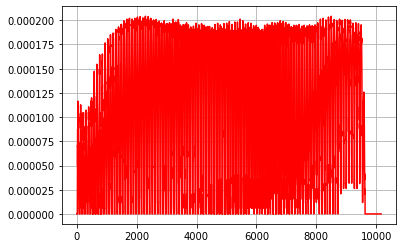

In [17]:
#计算权重
face_data_tes = face_data[100:150]
data_y_tes = data_y[100:150]
e = weigh(face_data_tes,data_y_tes)
plt.plot(range(len(e)),e,color='red')
plt.grid()
plt.show()

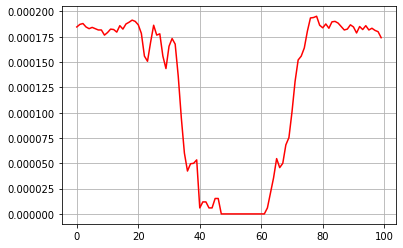

In [18]:
plt.plot(range(100),e[4000:4100],color='red')
plt.grid()
plt.show()

In [9]:
#归一化
mms = MinMaxScaler().fit(X_train)
X_train_ = mms.transform(X_train)
X_test_=mms.transform(X_test)

In [5]:
print(face_data.shape)

(3983, 10170)


-523.6909030327785
1.0 1.0 0.0


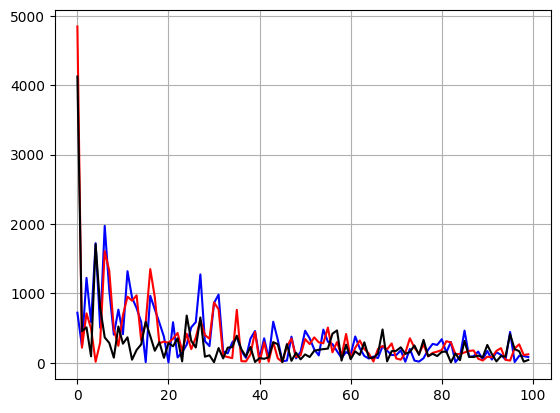

In [20]:
#可视化降维后特征差异
print(face_data[12][0])
ch1 = [abs(x-y) for x,y in zip(face_data[1000],face_data[3000])]
ch2 = [abs(x-y) for x,y in zip(face_data[1000],face_data[2000])]
ch3 = [abs(x-y) for x,y in zip(face_data[2000],face_data[3000])]
#plt.plot(range(20),face_data[1000][40:60],color='blue')
#plt.plot(range(20),face_data[2000][40:60],color='black')
#plt.plot(range(20),face_data[3000][40:60],color='red')
print(face_target[1000],face_target[2000],face_target[3000])
plt.plot(range(100),ch1[0:100],color='blue')
plt.plot(range(100),ch2[0:100],color='red')
plt.plot(range(100),ch3[0:100],color='black')
plt.grid()
plt.show()

In [10]:
#实例化模型
#gnb = GaussianNB().fit(X_train,Y_train) 
#mnb = MultinomialNB().fit(X_train,Y_train)
bnb = BernoulliNB().fit(X_train,Y_train) 
bnb_ = BernoulliNB(binarize=0.5).fit(X_train_,Y_train) 
#cnb = ComplementNB().fit(X_train,Y_train) 

In [11]:
#acc_score = gnb.score(X_test,Y_test)#高斯分布
#acc_score1 = mnb.score(X_test,Y_test)#多项式朴素贝叶斯分类器MultinomialNB
acc_score2 = bnb.score(X_test,Y_test)#伯劳尼朴素贝叶斯分类器BernoulliNB
acc_score2_1 = bnb_.score(X_test_,Y_test)
#acc_score3 = cnb.score(X_test,Y_test)#补集多项式
#print(acc_score,acc_score1,acc_score2,acc_score3)
#print(acc_score,acc_score2)
print(acc_score2,acc_score2_1)#PCA以后能得73~72

0.7138075313807531 0.6334728033472803


In [30]:
#混淆矩阵
Y_pred = bnb.predict(X_test)
for i in range(len(Y_pred)):
    correct = []
    if Y_pred[i]==Y_test[i]:
        correct.append(i)
print(len(correct))
from sklearn.metrics import confusion_matrix as CM
CM(Y_test,Y_pred)

1


array([[272, 193],
       [130, 600]])

In [12]:
#交叉验证
print(cross_val_score(bnb,face_data,face_target,cv=5,scoring='roc_auc'))
print(cross_val_score(bnb_,face_data,face_target,cv=5,scoring='roc_auc'))

[0.6223761  0.73445462 0.72937849 0.7074263  0.68266757]
[0.62155757 0.73320703 0.72930596 0.70731385 0.68179443]


In [13]:
#集成学习
clf = AdaBoostClassifier(base_estimator=bnb_, n_estimators=50)
scores = cross_val_score(clf, face_data,face_target, cv=5, scoring='roc_auc')
print('Adaboost-NB AUC：',scores.mean())

Adaboost-NB AUC： 0.7202583264664686


In [11]:
from sklearn.ensemble import BaggingClassifier
bagging = BaggingClassifier(gnb,n_estimators=20, max_samples=0.5, max_features=0.5)
scores1 = cross_val_score(bagging,face_data,face_target, cv=5, scoring='roc_auc')
print('BaggingAUC：',scores1.mean())

BaggingAUC： 0.6629615133910269
